In [1]:
#Import Dependencies

import pandas as pd
import numpy as np
import os

In [11]:
#Load CNN Output Predictions
logits = pd.read_csv('./CNN/logits/logits_20231126_16:07:42.csv')
logits.drop(labels=['Unnamed: 0'],inplace=True, axis=1)
logits.rename(columns={'0':'logits'}, inplace=True)

In [3]:
#Load Ground Truths
#Only tested on 2001 data with 
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}


year_list = np.arange(2001,2020,1)

images = []
label_df = []
for year in year_list:
    images.append(
        np.memmap(os.path.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8,
                  mode='r').reshape(
            (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(
        pd.read_feather(os.path.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))

images = np.concatenate(images)
label_df = pd.concat(label_df)

In [12]:
#Merge predictions with group truth and create deciles
full_df = label_df.merge(logits, how='left', left_index=True, right_index=True)
full_df['decile'] = pd.qcut(full_df['logits'], q=10, labels=False)

#Create decile plot to visualize results
decile_plot = full_df.groupby(by='decile').mean()

In [13]:
rfr = .01

decile_plot['I20/R5_ann'] = round(((1+decile_plot['Ret_5d']) ** 52) - 1, 3)
decile_plot['I20/R20_ann'] = round(((1+decile_plot['Ret_20d']) ** 12) - 1, 3)
decile_plot['volatility'] = round(((1+decile_plot['EWMA_vol']) ** 52) - 1,3)
decile_plot['sharpe_I20/R5'] = round((decile_plot['I20/R5_ann'] - rfr) / decile_plot['volatility'],3)
decile_plot

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol,logits,I20/R5_ann,I20/R20_ann,volatility,sharpe_I20/R5
decile,,,,,,,,,,,,,
0,2010-01-20 00:59:10.769230848,inf,3128247.00,-0.000216,0.005044,0.021140,0.007563,0.001694,0.408925,-0.011,0.062,0.092,-0.228
1,2010-01-09 05:39:46.606742016,inf,3303200.25,0.001034,0.005974,0.020775,0.008346,0.001717,0.439133,0.055,0.074,0.093,0.484
2,2010-01-05 03:18:00.084615936,inf,3298244.75,0.001154,0.006069,0.020592,0.008211,0.001760,0.453422,0.062,0.075,0.096,0.542
3,2010-01-08 22:07:16.452212480,inf,3345696.50,0.001549,0.006245,0.021631,0.008611,0.001649,0.464126,0.084,0.078,0.089,0.831
4,2010-01-08 09:45:08.481554688,inf,3427506.75,0.001342,0.006342,0.022512,0.008685,0.001656,0.473344,0.072,0.079,0.090,0.689
5,2010-01-09 10:46:09.672539904,inf,3409536.25,0.001689,0.006244,0.020452,0.008699,0.001640,0.481878,0.092,0.078,0.089,0.921
6,2010-01-20 20:41:05.951536384,inf,3565493.00,0.001980,0.006479,0.021328,0.008680,0.001652,0.490107,0.108,0.081,0.090,1.089
7,2010-01-28 08:34:43.694955520,inf,3580236.00,0.001945,0.006690,0.022598,0.009118,0.001614,0.498916,0.106,0.083,0.087,1.103
8,2010-01-27 16:36:48.852582656,inf,3656328.00,0.002226,0.005703,0.021524,0.008233,0.001746,0.509772,0.123,0.071,0.095,1.189


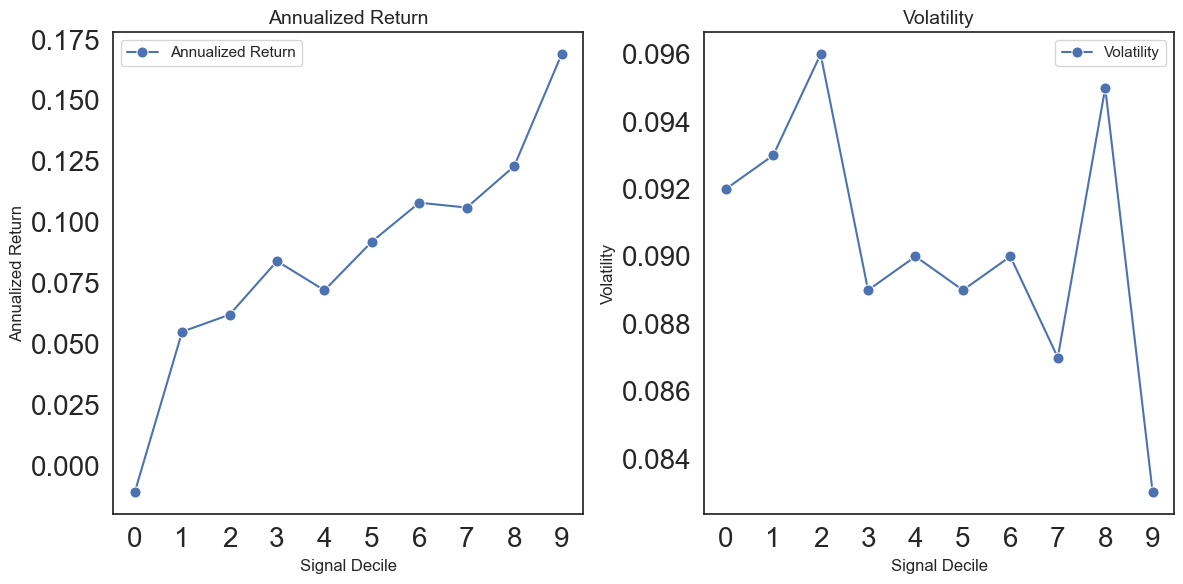

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming decile_plot has a column 'Ret_5d_annualized' and 'volatility'
# Replace 'your_dataframe' with the actual name of your DataFrame
sns.set(style="white")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Annualized Return
sns.lineplot(x=decile_plot.index, y=decile_plot['I20/R5_ann'], label='Annualized Return', marker='o', markersize=8, ax=axes[0])
axes[0].set_xlabel('Signal Decile', fontsize=12)
axes[0].set_ylabel('Annualized Return', fontsize=12)
axes[0].set_title('Annualized Return', fontsize=14)
axes[0].legend()

# Plot for Volatility
sns.lineplot(x=decile_plot.index, y=decile_plot.volatility, label='Volatility', marker='o', markersize=8, ax=axes[1])
axes[1].set_xlabel('Signal Decile', fontsize=12)
axes[1].set_ylabel('Volatility', fontsize=12)
axes[1].set_title('Volatility', fontsize=14)
axes[1].legend()

# Customize tick parameters
for ax in axes:
    ax.tick_params(axis='both', which='both', labelsize=20)
    ax.set_xticks(decile_plot.index)  # Set x-ticks to all values in the index

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()